In [36]:
import joblib
import shap
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
!pip install pandas --upgrade

     --------------------------------------- 10.8/10.8 MB 65.5 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3


In [29]:
# Load the contents of our "best-models.joblib" file into a variable called "loaded_joblib"
loaded_joblib = joblib.load("C:/Users/aharo/OneDrive/Documents/GitHub/Prediction-of-Product-Sales/Data/best-models.joblib")

In [30]:
# Save each object from the loaded_joblib dictionary as a separate variable
X_train = loaded_joblib['X_train']
X_test = loaded_joblib['X_test']
y_train = loaded_joblib['y_train']
y_test = loaded_joblib['y_test']
preprocessor = loaded_joblib['preprocessor']
lr = loaded_joblib['LinearRegression']
rf = loaded_joblib['RandomForestRegressor']

def get_feature_names(column_transformer):
    """Get feature names from all transformers."""
    output_features = []

    # Loop through all transformers
    for name, trans, columns in column_transformer.transformers_:
        if trans == 'drop':
            continue
        elif isinstance(trans, Pipeline): 
            trans = trans.steps[-1][1]
        if hasattr(trans, 'get_feature_names_out'):
            # If the transformer has a 'get_feature_names_out' method
            names = list(trans.get_feature_names_out(columns))
            output_features += names
        elif hasattr(trans, 'get_feature_names'):
            # If the transformer has a 'get_feature_names' method
            names = list(trans.get_feature_names(columns))
            output_features += names
        else:
            output_features += columns

    return output_features

feature_names = get_feature_names(preprocessor)


# Explaining our tree-based model with shap

In [31]:
# Create an X_shap and y_shap variable from your training data
X_shap = shap.sample(X_train, 100)
y_shap = y_train.loc[X_shap.index]

In [32]:
# Preprocess X_shap
X_shap_preprocessed = preprocessor.transform(X_shap)

In [41]:
import numpy as np
# Convert the preprocessed X_shap to DataFrame
X_shap_df = pd.DataFrame(X_shap_preprocessed.toarray(), columns=feature_names)

In [42]:
# Create a model explainer
explainer = shap.TreeExplainer(rf)

In [43]:
# Calculate the shap values for your model
shap_values = explainer.shap_values(X_shap_df)

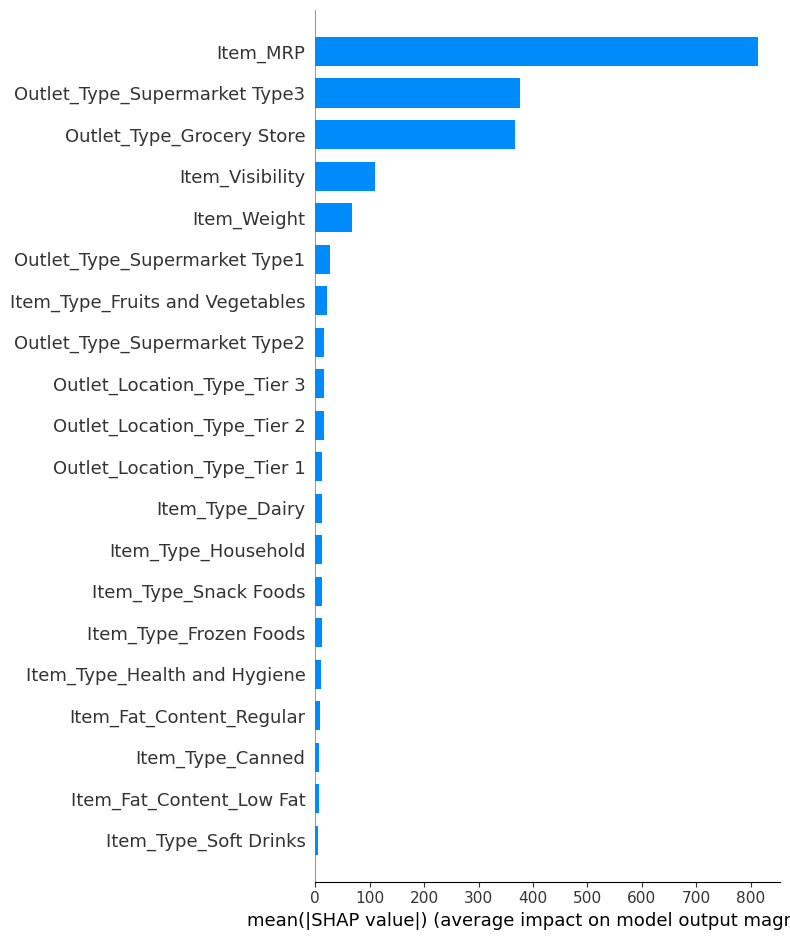

In [44]:
# Create a summary plot - with plot_type='bar'
shap.summary_plot(shap_values, X_shap_df, plot_type="bar", show=False)
plt.savefig("shap_importance.png", bbox_inches='tight')

# Summary Plot - Bar Version

This plot represents the average impact of each feature on the model's output. The y-axis shows the names of the features, and the x-axis represents the average absolute SHAP value, a measure of the magnitude of a feature's effect on the output. The larger the SHAP value, the higher the impact of the feature on the model's prediction.

# Comparison of Most Important Features: SHAP vs. Feature Importance

The SHAP values and Random Forest's feature importance don't completely align, and here's why:

1. SHAP values take into account not only the direct impact of a feature on the output but also its interaction with other features. This makes SHAP values a more comprehensive measure of feature importance.



2. The Random Forest model rates Item_MRP as the most important feature, while SHAP values rank Outlet_Type_Supermarket Type3 at the top. This could be because traditional feature importance measures like those from a Random Forest may be biased towards variables that have more categories or are numeric.

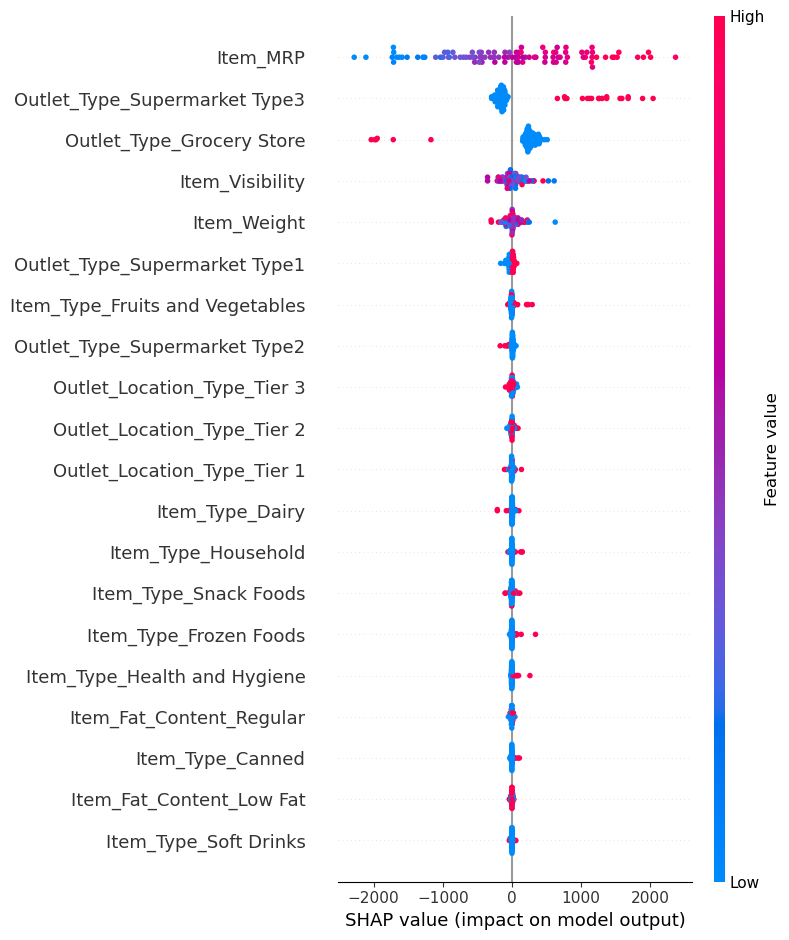

In [46]:
shap.summary_plot(shap_values, X_shap_df, show=False)
plt.savefig("shap_importance_dot.png", bbox_inches='tight')

# Summary Plot - Dot Version

This plot shows the impact of each feature on the model's prediction for individual instances. Each dot represents an instance (or a row) from the dataset. The color represents the feature's value (high in red, low in blue). The position on the x-axis shows whether the effect of that value is associated with a higher or lower prediction.

# Interpretation of the Top 3 Most Important Features


1. Outlet_Type_Supermarket Type3: This feature has the most significant impact on sales. If a store is a "Supermarket Type3", it tends to be associated with higher sales. Conversely, if a store is not of this type, it is likely to have lower sales.



2. Item_MRP: This is the price of the product. More expensive items (Item_MRP high, shown in red) are associated with higher sales, while cheaper items (low Item_MRP, shown in blue) tend to have lower sales.



3. Outlet_Type_Grocery Store: If an outlet is a grocery store, it is likely to have lower sales. If it's not a grocery store, the sales are likely to be higher.